In [14]:
print("What if you can achieve a better result!")

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 

from scipy.io import loadmat
import numpy as np
# Packages 



def read_hb_from_file(example_path): # Open the file and read through the first few lines to find where the data starts
    with open(example_path, 'r') as file:
        lines = file.readlines()
        data_start_line = None
        for i, line in enumerate(lines):
            if 'Data' in line:  # This should match the unique identifier of the data section
                data_start_line = i + 1
                # print(lines[data_start_line])
                break

    if data_start_line is not None:

        # Read the data section, skipping the lines of the metadata
        data = pd.read_csv(example_path, skiprows=data_start_line)

        # Now you have metadata and data as separate DataFrames
        # print(data)
    else:
        print("Data section not found.")
        
    np_data = data.to_numpy()
    ch_data = np_data[:, 1:1+52*2]
    
    return ch_data



def compute_delta(data):
    data = np.nan_to_num(data, 0)
    data += np.abs(np.min(data))
    
    light_700 = data[:,0::2].tolist()
    light_700_baseline = np.mean(light_700, (0,1)) + 1e-15
    delta_700 = -np.log10(light_700/light_700_baseline)

    light_830 = data[:,1::2].tolist()
    light_830_baseline = np.mean(light_830, (0,1)) + 1e-15
    delta_830 = -np.log10(light_830/light_830_baseline)
    return delta_700, delta_830


def get_closest_index_of_wavelength(wavelength, ref_ec):
    index_closest = np.argmin(np.abs(ref_ec[:,0] - wavelength))
    return index_closest
    



def extinction_coefficient_of_Hb(ref_file='extinction_coefficient.mat', low_wavelength=695, high_wavelength=830):
    ref_ec = loadmat(ref_file)['data']
    low_index = get_closest_index_of_wavelength(low_wavelength, ref_ec)
    high_index = get_closest_index_of_wavelength(high_wavelength, ref_ec)
    
    low_e_hbo, low_e_hbr = ref_ec[low_index, 1], ref_ec[low_index, 2]
    high_e_hbo, high_e_hbr = ref_ec[high_index, 1], ref_ec[high_index, 2]
     
    print(f'low_e_hbo: {low_e_hbo}, low_e_hbr: {low_e_hbr}')
    print(f'high_e_hbo: {high_e_hbo}, high_e_hbr: {high_e_hbr}')
    # e_HbO_704 = 298
    # e_HbR_704 = 1687.76
    # e_HbO_8279 = 965.2
    # e_HbR_8279 = 693.2
    E = np.array([[low_e_hbo, low_e_hbr],
                [high_e_hbo, high_e_hbr]])
    E_inv = np.linalg.inv(E)
    
    return E_inv 

def calculate_hb(delta_700, delta_830, E_inv, TOTAL_CHANNEL):
    
    all_channel_hb = np.empty((TOTAL_CHANNEL, delta_700.shape[0], 3))
    
    for ch in range(TOTAL_CHANNEL):
        
        ch_low_intensity = delta_700[:, ch]
        ch_high_intensity = delta_830[:, ch]

        ch_conc = np.array([ch_low_intensity, ch_high_intensity])
        delta_C = np.dot(E_inv, ch_conc)

        HbO, HbR = delta_C[0,:], delta_C[1,:]
        
        Hb = np.empty((len(HbO),3))
        Hb[:,0] = HbO
        Hb[:,1] = HbR
        Hb[:,2] = HbO + HbR
        
        all_channel_hb[ch] = Hb
    
    return all_channel_hb




def check_if_there_is_replicated_file(files_HCS, files_MDD):
    
    arr = []
    for f in files_HCS:
        name = f[2:5]
        if name in arr:
            print(name)
        else:
            arr.append(name)
    arr = []
    for f in files_MDD:
        name = f[2:5]
        if name in arr:
            print(name)
        else:
            arr.append(name)
    
    files_HCS = [f for f in files_HCS if f[-4:] == '.csv']
    files_MDD = [f for f in files_MDD if f[-4:] == '.csv']
    
    return files_HCS, files_MDD
    # arr_files_HCS = []


            
            
def convert_to_hb_using_MBLL(input_fold, output_fold):
    HCS_fold = input_fold + '/Controls/MES'
    MDD_fold = input_fold + '/Patients/MES'
    
    files_HCS = os.listdir(HCS_fold)
    files_MDD = os.listdir(MDD_fold)
    print(files_HCS)
    print(files_MDD)
    files_HCS, files_MDD = check_if_there_is_replicated_file(files_HCS, files_MDD)
    print(f"Total number of HCs: {len(files_HCS)}")
    print(f"Total number of MDDs: {len(files_MDD)}")

    HCS_LABEL = np.zeros(len(files_HCS))
    MDD_LABEL = np.ones(len(files_MDD))
    
    HCS_DATA = np.empty((len(files_HCS), 52, 1701, 3))
    MDD_DATA = np.empty((len(files_MDD), 52, 1701, 3))
    
    
    for sub, file in enumerate(files_HCS):
        
        TOTAL_CHANNEL = 52
        data = read_hb_from_file(HCS_fold + '/' + file)
        E_inv = extinction_coefficient_of_Hb()
        delta_700, delta_830 = compute_delta(data)
        Hb = calculate_hb(delta_700, delta_830, E_inv, TOTAL_CHANNEL)
        HCS_DATA[sub] = Hb

    for sub, file in enumerate(files_MDD):
        
        TOTAL_CHANNEL = 52
        data = read_hb_from_file(MDD_fold + '/' + file)
        E_inv = extinction_coefficient_of_Hb()
        delta_700, delta_830 = compute_delta(data)
        Hb = calculate_hb(delta_700, delta_830, E_inv, TOTAL_CHANNEL)
        MDD_DATA[sub] = Hb
    
    LABEL = np.concatenate((HCS_LABEL, MDD_LABEL), axis = 0)
    DATA = np.concatenate((HCS_DATA, MDD_DATA), axis = 0)
    print('Final - Data - shape', DATA.shape)
    return LABEL, DATA

What if you can achieve a better result!


This file will generate HbO, HbR and HbT using raw data of 695 and 830nm

In [15]:
input_fold = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/Prerequisite/RawData/Baseline_fnirs'
output_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/jy_process/diagnosis'
LABEL, DATA = convert_to_hb_using_MBLL(input_fold, output_fold)

# np.save(output_fold + '/hb_data_1701_695_830', DATA)
# np.save(output_fold + '/label', LABEL)

['CT043 VFT_MES_Probe1.csv', 'CT054 VFT_MES_Probe1.csv', 'CT059 VFT_MES_Probe1.csv', 'CT061 VFT_MES_Probe1.csv', 'CT030 VFT_MES_Probe1.csv', 'CT044 VFT_MES_Probe1.csv', 'CT048 VFT_MES_Probe1.csv', 'CT039 VFT_MES_Probe1.csv', 'CT021 VFT_MES_Probe1.csv', 'CT047 VFT_MES_Probe1.csv', 'CT026 VFT_MES_Probe1.csv', 'CT056 VFT_MES_Probe1.csv', 'CT018 VFT_MES_Probe1.csv', 'CT028 VFT_MES_Probe1.csv', 'CT070 VFT_MES_Probe1.csv', 'CT041 VFT_MES_Probe1.csv', 'CT067 VFT_MES_Probe1.csv', 'CT020 VFT_MES_Probe1.csv', 'CT057 VFT_MES_Probe1.csv', 'CT029 VFT_MES_Probe1.csv', 'CT031 VFT_MES_Probe1.csv', 'CT045 VFT_MES_Probe1.csv', 'CT073 VFTRerun_MES_Probe1.csv', 'CT014 VFT_MES_Probe1.csv', 'CT013 VFT_MES_Probe1.csv', 'CT055 VFT_MES_Probe1.csv', 'CT011 VFT_MES_Probe1.csv', 'CT038 VFT_MES_Probe1.csv', 'CT027 VFT_MES_Probe1.csv', '.DS_Store', 'CT063 VFT_MES_Probe1.csv', 'CT033 VFT_MES_Probe1.csv', 'CT002 VFT_MES_Probe1.csv', 'CT062 VFT_MES_Probe1.csv', 'CT005 VFT_MES_Probe1.csv', 'CT052 VFT_MES_Probe1.csv', '

/tmp/ipykernel_2347327/2737702587.py:47: RuntimeWarning: divide by zero encountered in log10
  delta_700 = -np.log10(light_700/light_700_baseline)
/tmp/ipykernel_2347327/2737702587.py:99: RuntimeWarning: invalid value encountered in add
  Hb[:,2] = HbO + HbR
/tmp/ipykernel_2347327/2737702587.py:51: RuntimeWarning: divide by zero encountered in log10
  delta_830 = -np.log10(light_830/light_830_baseline)


low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_hbr: 1949.04
high_e_hbo: 974.0, high_e_hbr: 693.04
low_e_hbo: 279.2, low_e_h

In [133]:
def save_data_label(data, label, fold):


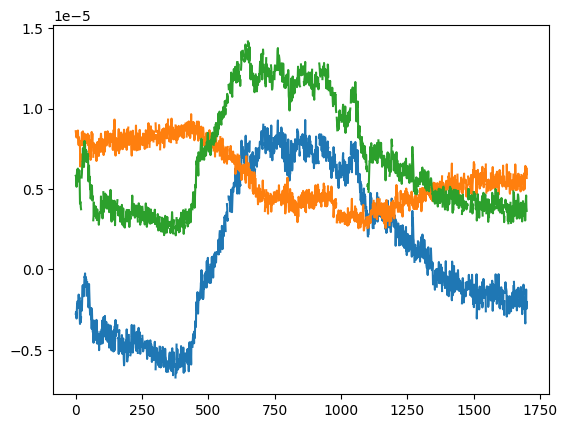

In [132]:

res = DATA[:70,...]
mean_hbo = np.mean(res[...,0], axis=(0,1))
mean_hbr = np.mean(res[...,1], axis=(0,1))
mean_hbt = np.mean(res[...,2], axis=(0,1))
plt.plot(mean_hbo)
plt.plot(mean_hbr)
plt.plot(mean_hbt)

In [122]:
LABEL.shape

DATA

array([[[[-2.06598692e-05, -6.04402832e-05, -8.11001524e-05],
         [-2.48583140e-05, -5.64447651e-05, -8.13030791e-05],
         [-2.50250526e-05, -5.50766196e-05, -8.01016722e-05],
         ...,
         [ 3.35295259e-06, -5.18768113e-05, -4.85238587e-05],
         [-2.53127815e-06, -4.79014844e-05, -5.04327626e-05],
         [-1.77466925e-06, -4.99944693e-05, -5.17691385e-05]],

        [[-1.74054360e-05, -6.16272802e-05, -7.90327161e-05],
         [-1.55012675e-05, -6.10633899e-05, -7.65646573e-05],
         [-2.12954806e-05, -5.42783550e-05, -7.55738356e-05],
         ...,
         [-7.74763137e-06, -6.34299264e-05, -7.11775578e-05],
         [-7.65860903e-06, -6.53002507e-05, -7.29588597e-05],
         [-9.37324637e-06, -6.28992993e-05, -7.22725456e-05]],

        [[-1.35971733e-05, -7.03669077e-05, -8.39640810e-05],
         [-1.12691723e-05, -7.26282808e-05, -8.38974531e-05],
         [-1.62625493e-05, -6.68409343e-05, -8.31034836e-05],
         ...,
         [-2.53882259e-0

(71, 52, 1701, 3)


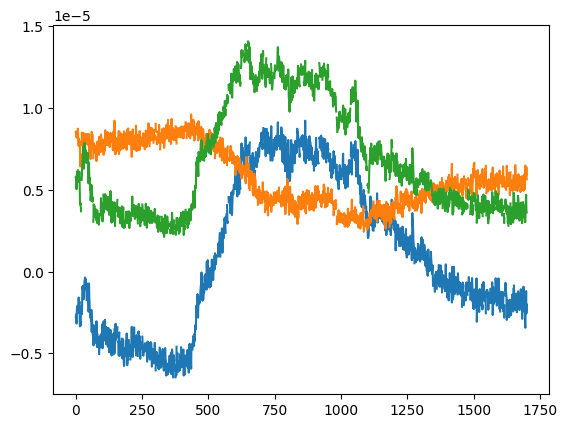

In [117]:
print(res.shape)




/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_21820/2001047394.py:18: RuntimeWarning: divide by zero encountered in log10
  delta_700 = -np.log10(light_700/light_700_baseline)


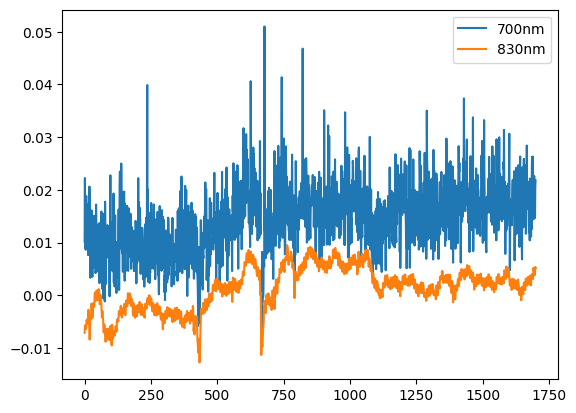

In [84]:
# Extinction coefficients for HbO and HbR at the two wavelengths
# Replace these with the actual values


# Matrix of extinction coefficients


# Inverse the matrix of extinction coefficients

ind_file = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/RawData/Baseline_fnirs/Patients/MES/Pt069 VFT_MES_Probe1(1).csv'

data = read_hb_from_file(ind_file)

data = np.nan_to_num(data, 0)
data += np.abs(np.min(data))
light_700 = data[:,0::2].tolist()
light_700_baseline = np.mean(light_700, (0,1))
delta_700 = -np.log10(light_700/light_700_baseline)


light_830 = data[:,1::2].tolist()
light_830_baseline = np.mean(light_830, (0,1))
delta_830 = -np.log10(light_830/light_830_baseline + 1e-6)

plt.plot(np.mean(delta_700, 1), label ='700nm')
plt.plot(np.mean(delta_830, 1), label ='830nm')
plt.legend()




/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_21820/3446044192.py:18: RuntimeWarning: divide by zero encountered in log10
  delta_700 = -np.log10(light_700/light_700_baseline)


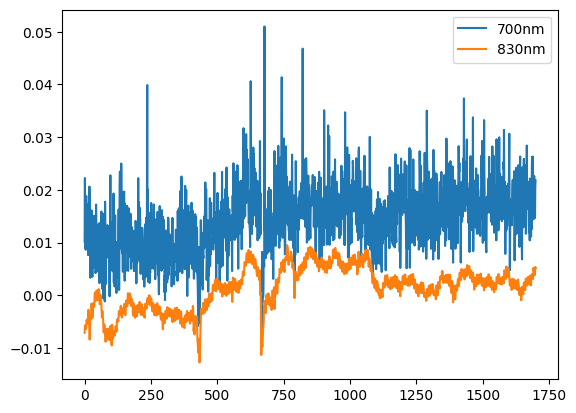

In [85]:
# Extinction coefficients for HbO and HbR at the two wavelengths
# Replace these with the actual values


# Matrix of extinction coefficients


# Inverse the matrix of extinction coefficients

ind_file = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/RawData/Baseline_fnirs/Patients/MES/PT069 VFT_MES_Probe1.csv'

data = read_hb_from_file(ind_file)

data = np.nan_to_num(data, 0)
data += np.abs(np.min(data))
light_700 = data[:,0::2].tolist()
light_700_baseline = np.mean(light_700, (0,1))
delta_700 = -np.log10(light_700/light_700_baseline)


light_830 = data[:,1::2].tolist()
light_830_baseline = np.mean(light_830, (0,1))
delta_830 = -np.log10(light_830/light_830_baseline + 1e-6)

plt.plot(np.mean(delta_700, 1), label ='700nm')
plt.plot(np.mean(delta_830, 1), label ='830nm')
plt.legend()




In [ ]:
# Extinction coefficients for HbO and HbR at the two wavelengths
# Replace these with the actual values


# Matrix of extinction coefficients


# Inverse the matrix of extinction coefficients
for i in range(1,70):
    plt.figure()
    if i < 10: 
        str_i = '00' + str(i)
    else:
        str_i = '0' + str(i)
    ind_file = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/RawData/Baseline_fnirs/Controls/MES/CT'+str_i+' VFT_MES_Probe1.csv'
    if not os.path.exists(ind_file):
        continue
    data = read_hb_from_file(ind_file)
    delta_700, delta_830 = compute_delta(data)

    # plt.plot(delta_700, label ='700nm')
    # plt.plot(delta_830, label ='830nm')
    
    # plt.plot(np.mean(light_700, 1), label ='700nm- original')
    # plt.plot(np.mean(light_830, 1), label ='830nm- original')    
    plt.plot(np.mean(delta_700, 1), label ='700nm')
    plt.plot(np.mean(delta_830, 1), label ='830nm')
    plt.legend()




(1701, 52)
(1701, 52)


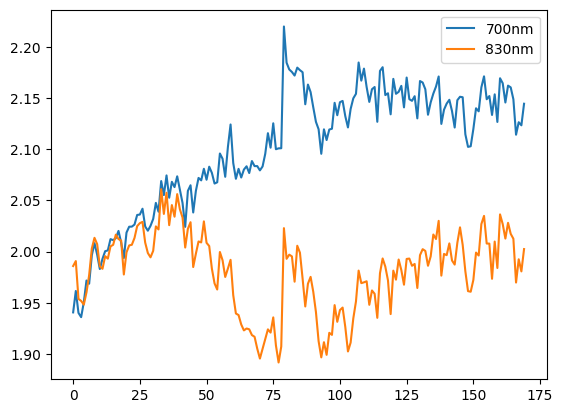

In [7]:
l1 = np.array(light_700)
l2 = np.array(light_830)

print(l1.shape)
print(l2.shape)

calculate_avg = lambda l1: np.mean(l1[:1700,:].reshape(-1, 10, 52), axis=1)
mean_sig = lambda a: np.mean(a, axis=1)

l1_avg = calculate_avg(l1)
l2_avg = calculate_avg(l2)

plt.plot(mean_sig(l1_avg), label ='700nm')
plt.plot(mean_sig(l2_avg), label ='830nm')  

plt.legend()


(2, 1701)
(2, 1701)


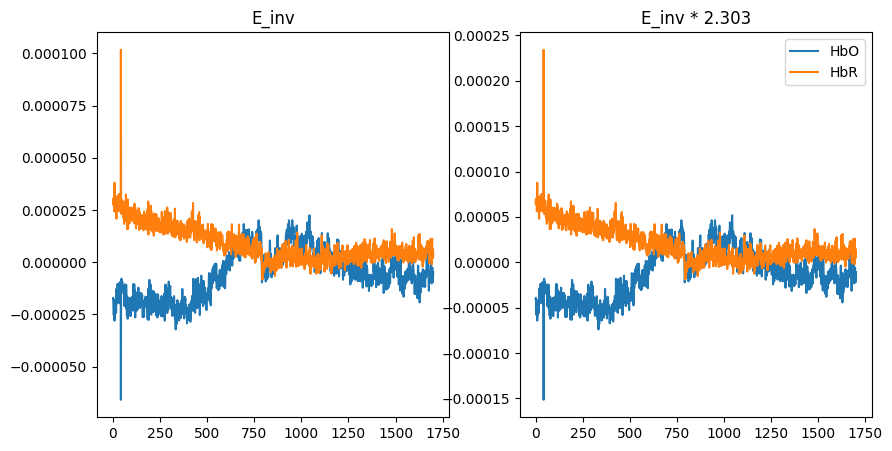

In [55]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

def extinction_coefficient_of_Hb():
    e_HbO_704 = 298
    e_HbR_704 = 1687.76
    e_HbO_8279 = 965.2
    e_HbR_8279 = 693.2
    E = np.array([[e_HbO_704, e_HbR_704],
                [e_HbO_8279, e_HbR_8279]])
    E_inv = np.linalg.inv(E)

    return E_inv 


E_inv = extinction_coefficient_of_Hb()


ch_low_intensity = np.mean(delta_700, 1)
ch_high_intensity = np.mean(delta_830, 1)

ch_conc = np.array([ch_low_intensity, ch_high_intensity])
delta_C = np.dot(E_inv, ch_conc)

print(delta_C.shape)

HbO, HbR = delta_C[0,:], delta_C[1,:]

axs[0].plot(HbO, label='HbO')
axs[0].plot(HbR, label='HbR')
axs[0].set_title('E_inv')

ch_low_intensity = np.mean(delta_700, 1)
ch_high_intensity = np.mean(delta_830, 1)

ch_conc = np.array([ch_low_intensity, ch_high_intensity])
delta_C = np.dot(E_inv*2.303, ch_conc)

print(delta_C.shape)

HbO, HbR = delta_C[0,:], delta_C[1,:]

axs[1].plot(HbO, label='HbO')
axs[1].plot(HbR, label='HbR')
axs[1].set_title('E_inv * 2.303')


plt.legend()


In [ ]:
def read_subject_mean_ch(file):
    data = np.load(file)
    hb = data[..., 0]
    for i in range(70):
        sub = hb[i, :, :]
        plt.figure()
        plt.plot(np.mean(sub, 0))
    
    print(data.shape)
    
read_subject_mean_ch('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/dataset_514/gabrielle_num_of_sub_141/hb_data.npy')

In [ ]:
data = np.concatenate((l1_avg[:, np.newaxis, :], l2_avg[:, np.newaxis, :]), axis=1)
data = np.transpose(data, (2,1,0))
print(data.shape)
import scipy.io

# Define the file path for saving the .mat file
mat_file_path = '/Users/shanxiafeng/Desktop/data.mat'

# Transform the data into a dictionary
data_dict = {'data': data}

# Save the data as a .mat file
scipy.io.savemat(mat_file_path, data_dict)
